In [1]:
##IMPORT
from fit_one_act import PINN_single
import torch
import numpy as np
import pandas as pd
from utilities import xavier_init_routine, xavier_init_routine
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys
from scipy.integrate import odeint
from torch import nn 

# Training parameters

In [3]:
#IMPORT H5PY data
import h5py

#import data
filename = './experimental_data/rCell2505.nwb'
with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data

    data = list(f[a_group_key])
    
f = h5py.File(filename, "r")
data = list(f['acquisition']['timeseries']['Activation']['repetitions']['repetition1']['data'])
data2 =  list(f['acquisition']['timeseries']['Activation']['repetitions']['repetition2']['data'])
data3 =  list(f['acquisition']['timeseries']['Activation']['repetitions']['repetition3']['data'])

#convert to array
arr = np.asarray(data)
arr2 = np.asarray(data2)
arr3 = np.asarray(data3)
current =  arr[1000:5995].squeeze()
current2 =  arr2[1000:5995].squeeze()
current3 =  arr3[1000:5995].squeeze()

#normalize
current =  current/current.max()
current2 =   current2/current2.max()
current3 =   current3/current3.max()


#select voltages betwwen -40 and +50 mV
v_act = np.arange(-90, 90, 10)
idx = np.where((v_act >= -40) & (v_act <= 50))
v = v_act[idx]
current =  current[:, idx].squeeze()
current2 =  current2[:, idx].squeeze()
current3 =  current3[:, idx].squeeze()


Keys: <KeysViewHDF5 ['acquisition', 'analysis', 'checksums', 'epochs', 'file_create_date', 'general', 'identifier', 'nwb_version', 'processing', 'session_description', 'session_start_time', 'stimulus']>


In [4]:
#####PARAMETERS#####
#plotting
PLOT = 1

#Optimizer
MAX_ITER_LBFGS = 50000
LINESEARCH =  "strong_wolfe" #"strong_wolfe" or None

#Model
NN_DEPTH = 10
NN_BREADTH = 20

#Training
ADAM_IT = 5000
WHOLE_DATA = False
DEVICE = "cuda"

if ~WHOLE_DATA:
    N_T = 4000 #Training set size

    
#ION Channel properties
E_K = torch.tensor([-96.2], dtype = torch.float64, device = DEVICE)
G_K = torch.tensor([0.1], dtype = torch.float64, device = DEVICE)

EXP_REP = 5+1 #repetition (activation voltage) to consider


In [5]:
#Build layer list
layers = [1] #nb of inputs
for i in range(NN_DEPTH):  # nb of layers
    layers.append(NN_BREADTH)
layers.append(1) #output size

#import  data
PATH = './experimental_data/Kv1.2/Exp/Kv1.2_2505_rep2_Current.txt'
data =  pd.read_csv(PATH, header=None, delim_whitespace=True)
t = np.concatenate((data[0], data[0], data[0]))


Ik =  np.concatenate((current[:, EXP_REP], current2[:, EXP_REP],  current3[:, EXP_REP])) #data[EXP_REP] # pd.read_csv("surrogate_noise5.csv", header=None)[EXP_REP] #


PATH_act = './experimental_data/Kv1.2/Exp/Kv1.2_2505_rep2_Stimulus.txt'
v_act = pd.read_csv(PATH_act, header=None, delim_whitespace=True).to_numpy().squeeze()
v_train = v_act[EXP_REP]


lb = t.min(0)
ub = t.max(0)

# Training

In [6]:
############ TRAINING #############

if WHOLE_DATA:
    #use all the data
    t_train = t
    Ik_train = Ik.to_numpy()

else:
    idx = np.arange(11)  # make sure rise is in training data
    idx = np.concatenate((idx, np.random.choice(t.shape[0], N_T, replace=False)))

    t_train = t[idx]#.to_numpy()
    Ik_train = Ik[idx]#.to_numpy()
    
# Build model
model = PINN_single(t_train, Ik_train, layers, lb, ub, v_train, device= DEVICE, max_iter_lbfgs=MAX_ITER_LBFGS)
model.apply(xavier_init_routine)  # initialize nn

# TRAIN
model.train(ADAM_IT)

It: 0, Loss: 1.236e+01
Loss: 7.014e+00
Loss: 5.014e+00
Loss: 3.576e+00
Loss: 1.574e+01
Loss: 2.358e+00
Loss: 1.915e+00


# Plot results

In [22]:
#Functions
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    """

    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def sig2(v):
    """computes sigmoid function for m_tau"""
    vBreak = -79.1345
    offset1 = 0.27482
    amp1 =  38.4251
    vh1 = -53.4992
    slope1 = 5.0003
    offset2 = 0.54781
    amp2 = 5.6426
    vh2 = -18.1111
    slope2 = 12.5306
    
    sigswitch = 1/(1+np.exp((v-vBreak)/3.0))
    sig2 = (sigswitch*(offset1+(amp1)/(1+np.exp((v-vh1)/-slope1)))) + ((1-sigswitch)*offset2+(amp2-offset2)/(1+np.exp((v-vh2)/slope2)))
	
    return sig2

def func(p, t, p_inf, p_tau):
    """ode function"""
    dp = (p_inf - p) / p_tau
    return dp



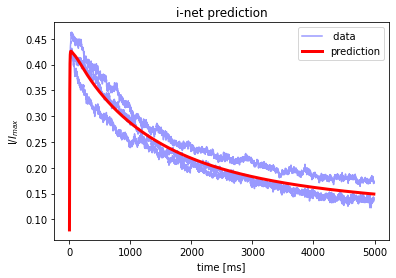

In [21]:
#i-net predictions
t = np.arange(0, 499, 0.1)
i_pred = model.predict(np.squeeze(t))
i_pred = ((i_pred + 1)*(model.I.max().cpu().detach().numpy() - model.I.min().cpu().detach().numpy())/2+model.I.min().cpu().detach().numpy())
plt.title("i-net prediction")

plt.plot(current[:4990, EXP_REP], label = " data",  color=lighten_color('b', 0.4))
plt.plot(current2[:4990, EXP_REP],  color=lighten_color('b', 0.4))
plt.plot(current3[:4990, EXP_REP], color=lighten_color('b', 0.4))


plt.xlabel("time [ms]")
plt.ylabel(r"I/$I_{max}$")
plt.plot(np.squeeze(i_pred), 'r', label = "prediction", linewidth = 3.0)
plt.legend()
plt.savefig("plots/net_pred_all.svg")

plt.show()

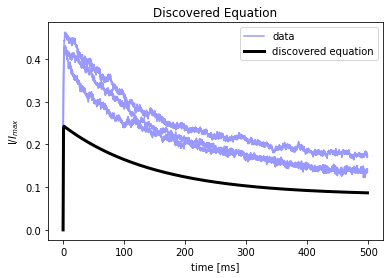

In [25]:
t = np.arange(0,499,0.1)

plt.title(r"Discovered Equation")
m_reg = odeint(func, 0, t, args = (model.m_inf.cpu().detach().numpy(), model.m_tau.cpu().detach().numpy()*5))
h_reg = odeint(func, 1, t, args = (model.h_inf.cpu().detach().numpy(), model.h_tau.cpu().detach().numpy()*500))
I_reg =  0.1*m_reg*m_reg*h_reg*(v_act[EXP_REP] - (-96.2))
#plt.plot(t, Ik, color=lighten_color('b', 0.4), label = "data")
plt.plot(t, current[:4990, EXP_REP], label = "data",  color=lighten_color('b', 0.4))
plt.plot(t, current2[:4990, EXP_REP],   color=lighten_color('b', 0.4))
plt.plot(t, current3[:4990, EXP_REP], color=lighten_color('b', 0.4))
plt.plot(t, I_reg, 'k', label = 'discovered equation', linewidth=3.0)

plt.legend()
plt.ylabel(r"I/$I_{max}$")
plt.xlabel("time [ms]")
           
plt.savefig("plots/eq_pred_all.svg")


# MSEs

In [28]:
loss = nn.MSELoss()
i_pred = np.squeeze(i_pred)
netMSE = loss(torch.Tensor(np.concatenate((i_pred[:4990], i_pred[:4990], i_pred[:4990]))), torch.Tensor(np.concatenate((current[:4990, EXP_REP],  current[:4990, EXP_REP], current[:4990, EXP_REP])))) #loss(torch.Tensor(np.squeeze(i_pred)), torch.Tensor(Ik.to_numpy))
print('%.10f' %netMSE)

0.0006753945


In [29]:
eqMSE =loss(torch.tensor(np.concatenate((I_reg, I_reg, I_reg)).squeeze(), dtype = torch.float64), torch.tensor(np.concatenate((current[:4990, EXP_REP],  current[:4990, EXP_REP], current[:4990, EXP_REP])), dtype = torch.float64))
print('%.10f' %eqMSE)

0.0160327841
